## I’m Something of a Painter Myself

This notebook implements a CycleGAN to translate landscape photos into Monet-style paintings.
The project is based on the Kaggle competition “I’m Something of a Painter Myself”,
which provides unpaired datasets of Monet paintings and natural photos.

Objective: Train a CycleGAN that captures Monet’s artistic style and transforms input photos into images resembling Monet paintings.

##1. Introduction

### Goal

Translate landscape photos into Monet-style images using a CycleGAN.

### Dataset
	•	Monet paintings: 300 images
	•	Photo images: 7,038 images
	•	Size: 256×256 RGB

### Approach
	•	Implement CycleGAN with two Generators (Photo→Monet, Monet→Photo) and two Discriminators.
	•	Loss functions: Adversarial loss, Cycle-consistency loss, and Identity loss.
	•	Optimizer: Adam (lr=2e-4, β1=0.5).
	•	Experiment with hyperparameters such as learning rate and batch size.

In [130]:
import os, json, random
from pathlib import Path
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn

from torch.amp import autocast, GradScaler

from tqdm.auto import tqdm

from glob import glob
import random
import itertools


plt.style.use('default')

print(f"PyTorch: {torch.__version__}")
print(f"Numpy: {np.__version__}")

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

cudnn.benchmark = True
cudnn.deterministic = False

use_amp = (device.type == 'cuda')
scaler = GradScaler(device.type if use_amp else 'cpu', enabled=use_amp)

def now(): return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

PyTorch: 2.8.0+cu126
Numpy: 2.0.2
Using device: cuda


## 2. Data Exploration


In [131]:
if os.path.exists("/content/kaggle/input/gan-getting-started"):
    DATA_DIR = Path("/content/kaggle/input/gan-getting-started")
else:
    DATA_DIR = Path("/kaggle/input/gan-getting-started")

MONET_DIR = DATA_DIR / "monet_jpg"
PHOTO_DIR = DATA_DIR / "photo_jpg"

monet_paths = sorted(MONET_DIR.glob("*.jpg"))
photo_paths = sorted(PHOTO_DIR.glob("*.jpg"))

print(f"Monet paintings: {len(monet_paths)}")
print(f"Photos: {len(photo_paths)}")

sample = Image.open(monet_paths[0])
print(f"Image size: {sample.size}, mode: {sample.mode}")

Monet paintings: 300
Photos: 7038
Image size: (256, 256), mode: RGB


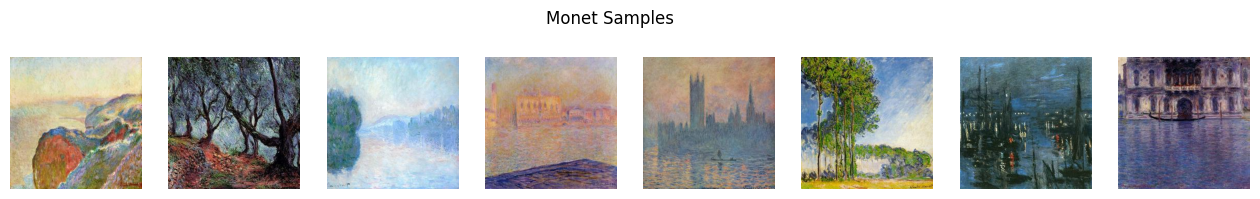

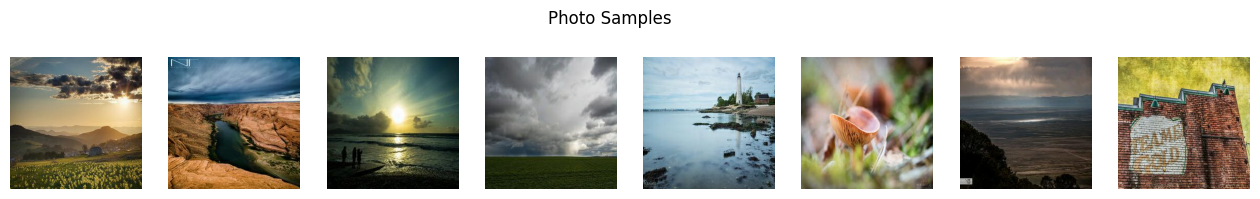

In [132]:
def show_grid(paths, n=8, title=""):
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2.5))
    for i, ax in enumerate(axes):
        with Image.open(paths[i]) as im:
            ax.imshow(im)
        ax.axis("off")
    fig.suptitle(title, fontsize=12, y=0.95)
    plt.show()

show_grid(monet_paths[:8], title="Monet Samples")
show_grid(photo_paths[:8], title="Photo Samples")

## 3. Data Preprocessing & Dataset

In [133]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

class ImageDataset(Dataset):
    def __init__(self, monet_paths, photo_paths, transform=None):
        self.monet_paths = monet_paths
        self.photo_paths = photo_paths
        self.transform = transform

    def __len__(self):
        return max(len(self.monet_paths), len(self.photo_paths))

    def __getitem__(self, idx):
        monet_path = self.monet_paths[idx % len(self.monet_paths)]
        photo_path = self.photo_paths[idx % len(self.photo_paths)]

        monet_img = Image.open(monet_path).convert("RGB")
        photo_img = Image.open(photo_path).convert("RGB")

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return {"monet": monet_img, "photo": photo_img}

dataset = ImageDataset(monet_paths, photo_paths, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    pin_memory=True
)

batch = next(iter(dataloader))
print("Monet batch:", batch["monet"].shape)
print("Photo batch:", batch["photo"].shape)

Monet batch: torch.Size([1, 3, 256, 256])
Photo batch: torch.Size([1, 3, 256, 256])


## 4. CycleGAN Model

At first, I experimented with a **DCGAN** to generate Monet paintings directly from random noise.  
However, due to the small dataset size (only 300 Monet images), the model suffered from **mode collapse** and produced limited variety.

To address this issue, I adopted a **CycleGAN** approach for **unpaired image-to-image translation**.  
This method leverages both Monet paintings and natural photos, enabling the model to transfer Monet’s style while preserving the structure of the original photo.

- **Generators (ResNet-based):** Photo → Monet, Monet → Photo  
- **Discriminators (PatchGAN):** Monet domain and Photo domain  
- **Losses:** Adversarial loss, Cycle-consistency loss, Identity loss  
- **Training:** Adam optimizer (lr=2e-4, β1=0.5), 20 epochs, with data augmentation  

Compared to the DCGAN baseline, CycleGAN produced more stable training and generated higher-quality, diverse Monet-style images.

In [134]:
import torch.nn as nn
import functools

class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer, use_dropout=False):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, bias=False),
            norm_layer(dim),
            nn.ReLU(True),
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        layers += [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, bias=False),
            norm_layer(dim),
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)

def init_weights(net):
    for m in net.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
            if hasattr(m, 'weight') and m.weight is not None:
                nn.init.normal_(m.weight, 1.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)

In [135]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_blocks=9, ngf=64, norm_layer=nn.InstanceNorm2d):
        super().__init__()
        layers = []

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, bias=False),
            norm_layer(ngf),
            nn.ReLU(True),
        ]

        in_c = ngf
        for _ in range(2):
            out_c = in_c * 2
            layers += [
                nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1, bias=False),
                norm_layer(out_c),
                nn.ReLU(True),
                nn.AvgPool2d(kernel_size=1, stride=1)
            ]
            in_c = out_c

        for _ in range(n_blocks):
            layers += [ResnetBlock(in_c, norm_layer=norm_layer)]

        for _ in range(2):
            out_c = in_c // 2
            layers += [
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ReflectionPad2d(1),
                nn.Conv2d(in_c, out_c, kernel_size=3, bias=False),
                norm_layer(out_c),
                nn.ReLU(True),
            ]
            in_c = out_c

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_c, output_nc, kernel_size=7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*layers)
        init_weights(self)

    def forward(self, x):
        return self.model(x)

In [136]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc=3, ndf=64, n_layers=3, norm_layer=nn.InstanceNorm2d):
        super().__init__()
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
        ]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=4, stride=2, padding=1, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True),
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=4, stride=1, padding=1, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True),
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)]
        self.model = nn.Sequential(*sequence)
        init_weights(self)

    def forward(self, x):
        return self.model(x)

In [137]:
G_XY = ResnetGenerator().to(device)
G_YX = ResnetGenerator().to(device)

D_Y = NLayerDiscriminator().to(device)
D_X = NLayerDiscriminator().to(device)

In [138]:
mse = nn.MSELoss()

def gan_loss(pred, target_is_real: bool, smooth: bool = False):
    if target_is_real:
        target = torch.ones_like(pred)
        if smooth:
            target = target * 0.9
    else:
        target = torch.zeros_like(pred)
    return mse(pred, target)

lr_G = 2e-4
lr_D = 5e-5

opt_G  = torch.optim.Adam(list(G_XY.parameters()) + list(G_YX.parameters()), lr=lr_G, betas=(0.5, 0.999))
opt_Dy = torch.optim.Adam(D_Y.parameters(), lr=lr_D, betas=(0.5, 0.999))
opt_Dx = torch.optim.Adam(D_X.parameters(), lr=lr_D, betas=(0.5, 0.999))

epochs_total = 12
def linear_decay_scheduler(opt, start_epoch, total_epoch):
    def lr_lambda(e):
        return 1.0 if e < start_epoch else max(0.0, 1.0 - (e - start_epoch) / (total_epoch - start_epoch))
    return torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

decay_start = epochs_total // 2
sch_G  = linear_decay_scheduler(opt_G,  decay_start, epochs_total)
sch_Dy = linear_decay_scheduler(opt_Dy, decay_start, epochs_total)
sch_Dx = linear_decay_scheduler(opt_Dx, decay_start, epochs_total)

λ_cyc = 15.0
λ_id  = 0.7 * λ_cyc

In [139]:
from torchvision.transforms import InterpolationMode

IMG_SIZE = 256

tfm_train = transforms.Compose([
    transforms.Resize(286, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
class UnpairedMonetPhoto(Dataset):
    def __init__(self, monet_dir, photo_dir, transform, steps_per_epoch=None):
        self.monet = sorted(glob(str(Path(monet_dir) / '*.jpg')))
        self.photo = sorted(glob(str(Path(photo_dir) / '*.jpg')))
        self.tfm = transform
        self.steps_per_epoch = steps_per_epoch

    def __len__(self):
        return max(len(self.monet), len(self.photo))

    def __getitem__(self, idx):
        monet_path = random.choice(self.monet)
        photo_path = self.photo[random.randrange(len(self.photo))]
        m = self.tfm(Image.open(monet_path).convert('RGB'))
        p = self.tfm(Image.open(photo_path).convert('RGB'))
        return {'monet': m, 'photo': p}

train_ds = UnpairedMonetPhoto(MONET_DIR, PHOTO_DIR, tfm_train, steps_per_epoch=300)

dl_kwargs = dict(batch_size=1, shuffle=True, num_workers=2, drop_last=True)
if device.type == 'cuda':
    dl_kwargs.update(dict(pin_memory=True, persistent_workers=True))
train_dl = DataLoader(train_ds, **dl_kwargs)

In [140]:
class ImagePool:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.images = []

    def query(self, new_imgs):
        out = []
        for img in new_imgs:
            img = img.detach()
            if len(self.images) < self.max_size:
                self.images.append(img)
                out.append(img)
            else:
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, self.max_size)
                    tmp = self.images[idx].clone()
                    self.images[idx] = img
                    out.append(tmp)
                else:
                    out.append(img)
        return torch.stack(out, dim=0)

pool_Y = ImagePool(20)
pool_X = ImagePool(20)

Epoch 1/12:   0%|          | 0/300 [00:00<?, ?it/s]

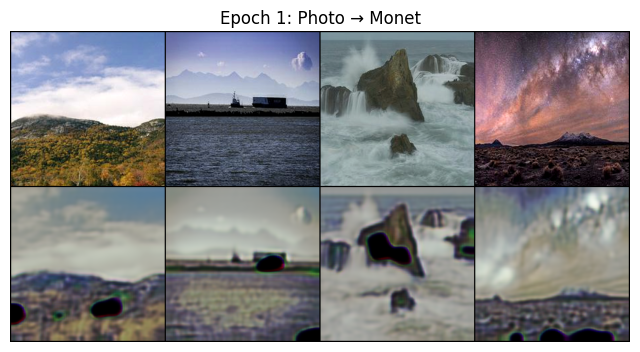

Epoch 2/12:   0%|          | 0/300 [00:00<?, ?it/s]

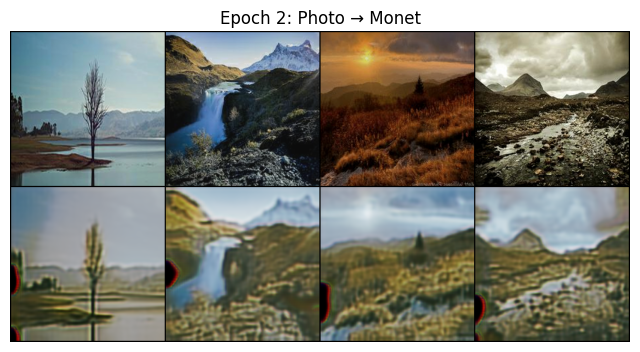

Epoch 3/12:   0%|          | 0/300 [00:00<?, ?it/s]

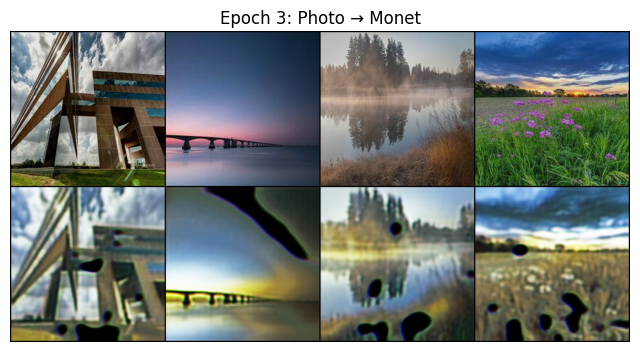

Epoch 4/12:   0%|          | 0/300 [00:00<?, ?it/s]

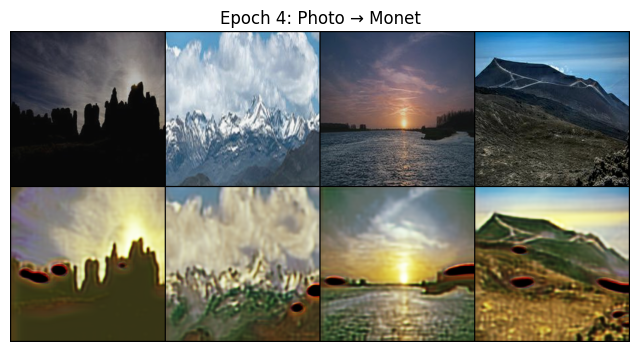

Epoch 5/12:   0%|          | 0/300 [00:00<?, ?it/s]

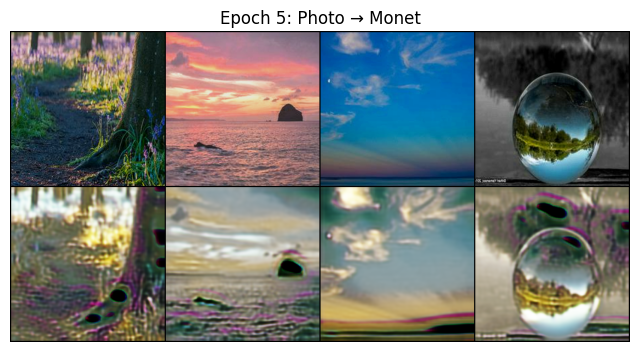

Epoch 6/12:   0%|          | 0/300 [00:00<?, ?it/s]

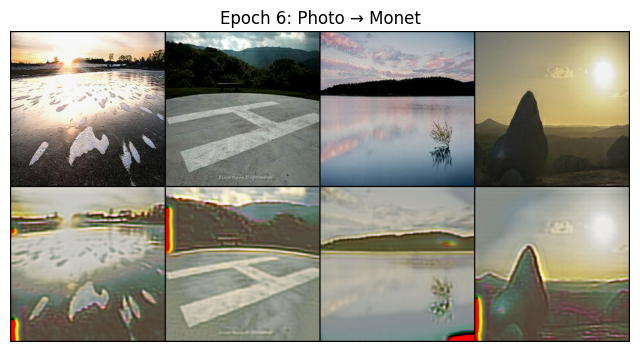

Epoch 7/12:   0%|          | 0/300 [00:00<?, ?it/s]

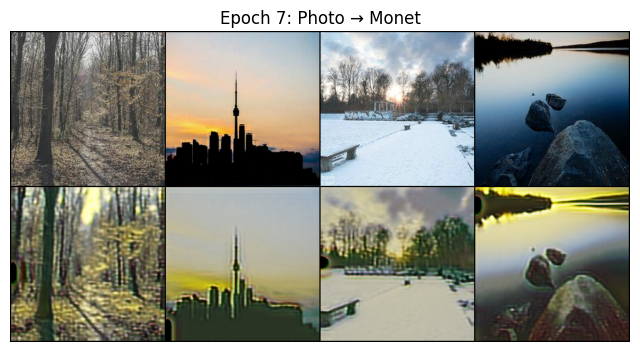

Epoch 8/12:   0%|          | 0/300 [00:00<?, ?it/s]

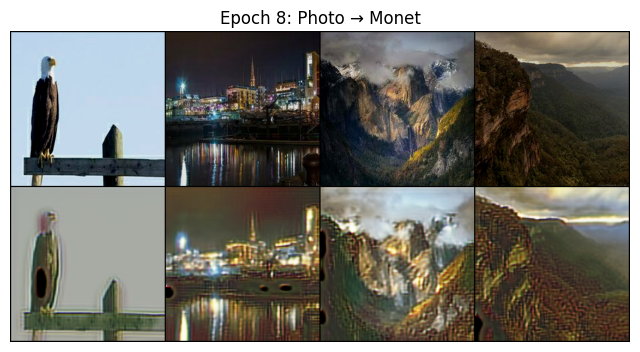

Epoch 9/12:   0%|          | 0/300 [00:00<?, ?it/s]

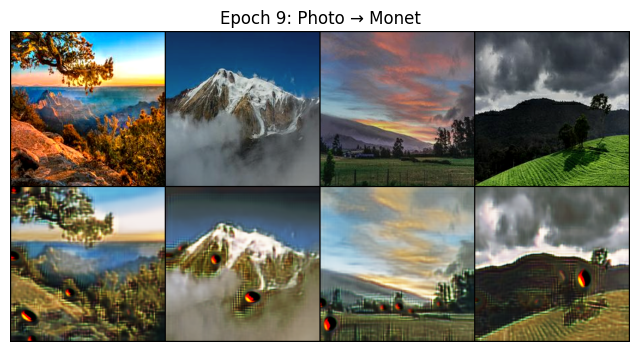

Epoch 10/12:   0%|          | 0/300 [00:00<?, ?it/s]

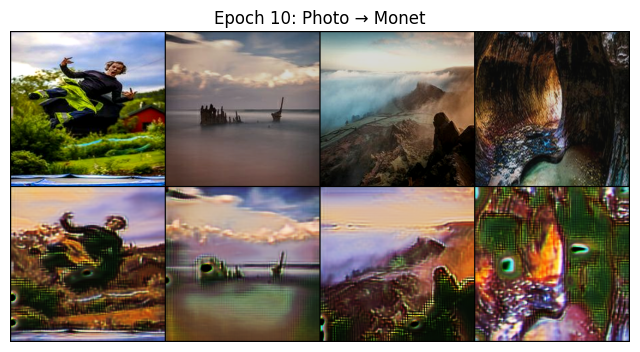

Epoch 11/12:   0%|          | 0/300 [00:00<?, ?it/s]

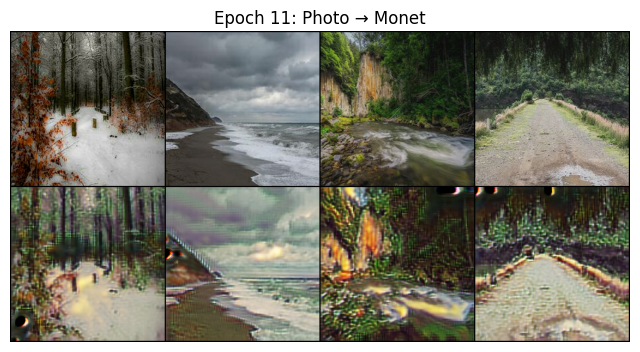

Epoch 12/12:   0%|          | 0/300 [00:00<?, ?it/s]

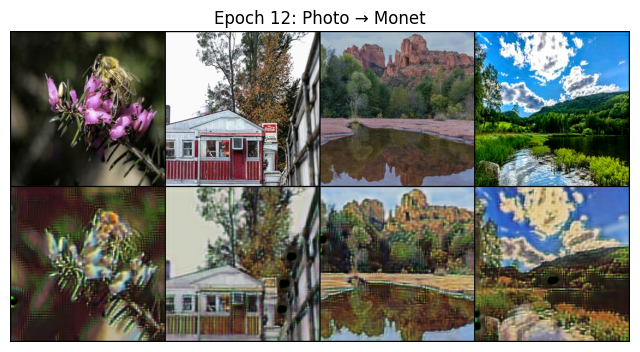

In [141]:
from torch.nn import functional as F
import torchvision

preview_idx = torch.randint(0, len(train_ds), (4,))
def get_preview_batch():
    xs, ys = [], []
    for i in preview_idx:
        item = train_ds[i]
        xs.append(item['photo'])
        ys.append(item['monet'])
    x = torch.stack(xs).to(device)
    y = torch.stack(ys).to(device)
    return x, y

def denorm(x):
    return (x.clamp(-1, 1) + 1) * 0.5

epochs    = epochs_total
log_every = 100
smooth_lb = True

x_vis = next(iter(train_dl))['photo'][:4].to(device)

losses_G, losses_Dy, losses_Dx = [], [], []
global_step = 0

for epoch in range(1, epochs + 1):
    G_XY.train(); G_YX.train(); D_Y.train(); D_X.train()

    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{epochs}", total=300)
    step = 0

    for batch in train_dl:
        x = batch['photo'].to(device, non_blocking=True)
        y = batch['monet'].to(device, non_blocking=True)

        opt_Dy.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, enabled=use_amp):
            fake_y_new = G_XY(x)
            fake_y_buf = pool_Y.query(fake_y_new)

            Dy_real = D_Y(y)
            Dy_fake = D_Y(fake_y_buf)
            loss_Dy = 0.5 * (gan_loss(Dy_real, True,  smooth=smooth_lb) +
                             gan_loss(Dy_fake, False, smooth=smooth_lb))
        scaler.scale(loss_Dy).backward()
        scaler.step(opt_Dy)

        opt_Dx.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, enabled=use_amp):
            fake_x_new = G_YX(y)
            fake_x_buf = pool_X.query(fake_x_new)

            Dx_real = D_X(x)
            Dx_fake = D_X(fake_x_buf)
            loss_Dx = 0.5 * (gan_loss(Dx_real, True,  smooth=smooth_lb) +
                             gan_loss(Dx_fake, False, smooth=smooth_lb))
        scaler.scale(loss_Dx).backward()
        scaler.step(opt_Dx)

        opt_G.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, enabled=use_amp):
            fake_y = G_XY(x)
            fake_x = G_YX(y)

            rec_x  = G_YX(fake_y)
            rec_y  = G_XY(fake_x)

            loss_G_gan = gan_loss(D_Y(fake_y), True, smooth=False) + \
                         gan_loss(D_X(fake_x), True, smooth=False)
            loss_cyc   = F.l1_loss(rec_x, x) + F.l1_loss(rec_y, y)

            idt_y = G_XY(y)
            idt_x = G_YX(x)
            loss_id = F.l1_loss(idt_y, y) + F.l1_loss(idt_x, x)

            loss_G = loss_G_gan + λ_cyc*loss_cyc + λ_id*loss_id

        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        global_step += 1
        losses_G.append(loss_G.item())
        losses_Dy.append(loss_Dy.item())
        losses_Dx.append(loss_Dx.item())

        step += 1
        if step % log_every == 0:
            pbar.set_postfix({
                "D_Y": f"{loss_Dy.item():.3f}",
                "D_X": f"{loss_Dx.item():.3f}",
                "G":   f"{loss_G.item():.3f}"
            })
        pbar.update(1)
        if step >= 300:
            break

    sch_G.step(); sch_Dy.step(); sch_Dx.step()

    G_XY.eval()
    with torch.no_grad(), autocast(device_type=device.type, enabled=use_amp):
        x_show, _ = get_preview_batch()
        y_pred = denorm(G_XY(x_show)).cpu()
        x_show = denorm(x_show).cpu()

    grid = torchvision.utils.make_grid(torch.cat([x_show, y_pred], dim=0), nrow=4)
    plt.figure(figsize=(8,6))
    plt.imshow(grid.permute(1,2,0).numpy()); plt.axis('off')
    plt.title(f"Epoch {epoch}: Photo → Monet")
    plt.show()

## 5. Results

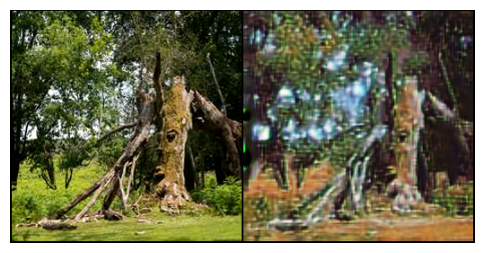

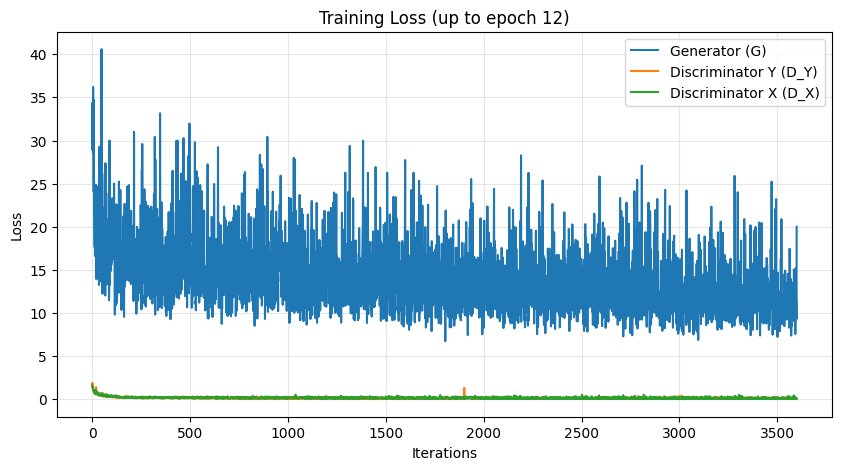

In [147]:
    G_XY.eval()
    with torch.no_grad(), autocast(device_type=device.type, enabled=use_amp):
        y_pred = denorm(G_XY(x_vis)).cpu()
        x_show = denorm(x_vis).cpu()
    grid = torchvision.utils.make_grid(torch.cat([x_show, y_pred], dim=0), nrow=4)
    plt.figure(figsize=(6,6)); plt.imshow(grid.permute(1,2,0).numpy()); plt.axis('off'); plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(losses_G,  label="Generator (G)")
    plt.plot(losses_Dy, label="Discriminator Y (D_Y)")
    plt.plot(losses_Dx, label="Discriminator X (D_X)")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (up to epoch {epoch})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [143]:
WORK_ROOT = Path("/kaggle/working") if os.path.exists("/kaggle/working") else Path("./working")
OUT_DIR   = WORK_ROOT / "images"
OUT_DIR.mkdir(parents=True, exist_ok=True)

G_XY.eval()
photo_files = sorted(glob(str(PHOTO_DIR / "*.jpg")))
num_images  = min(7000, len(photo_files))

from PIL import Image
def to_pil(x):
    x = (denorm(x)*255.0).byte().cpu().permute(1,2,0).numpy()
    return Image.fromarray(x)

with torch.no_grad():
    for idx in tqdm(range(num_images), desc="Generating"):
        im = Image.open(photo_files[idx]).convert("RGB")
        im = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])(im).unsqueeze(0).to(device)
        out = G_XY(im)[0]
        to_pil(out).save(OUT_DIR / f"{idx}.jpg", quality=95)

zip_path = WORK_ROOT / "images.zip"
import zipfile
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_STORED) as z:
    for p in sorted(OUT_DIR.glob("*.jpg")):
        z.write(p, arcname=f"images/{p.name}")

print("Saved:", zip_path)

Generating:   0%|          | 0/7000 [00:00<?, ?it/s]

Saved: working/images.zip


G_XY.eval()
with torch.no_grad(), autocast(device_type=device.type, enabled=use_amp):
    y_pred = denorm(G_XY(x_vis)).cpu()
    x_show = denorm(x_vis).cpu()

    grid = torchvision.utils.make_grid(torch.cat([x_show, y_pred], dim=0), nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(losses_G,  label="Generator (G)")
    plt.plot(losses_Dy, label="Discriminator Y (D_Y)")
    plt.plot(losses_Dx, label="Discriminator X (D_X)")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (up to epoch {epoch})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
